In [ ]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay
)
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.base import BaseEstimator

In [ ]:


def plot_confusion(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


def plot_feature_importance(model: BaseEstimator, feature_names: list):
    if hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        indices = importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(indices)), importances[indices], align="center")
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.title("Feature Importances")
        plt.gca().invert_yaxis()
        plt.show()


def plot_roc_curve(y_test, y_probs, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} - ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


def build_and_evaluate_pipeline(data: pd.DataFrame, target_column: str, model, param_grid: dict):
    y = data['loan_status']
    X = data.drop(columns='loan_status')

    # Undersampling
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(X, y)
    print(" Class distribution after undersampling:")
    print(y_resampled.value_counts())

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    # Preprocessing
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])

    grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    print(f" Best Parameters for {model.__class__.__name__}: {grid.best_params_}")
    print(f" Best CV Accuracy: {grid.best_score_:.4f}")

    y_pred = best_model.predict(X_test)
    print(f" {model.__class__.__name__} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plot_confusion(y_test, y_pred, model.__class__.__name__)

    # Feature Importance (for tree-based models)
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        print(" Plotting Feature Importances...")
        # Get final feature names after transformation
        feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
        plot_feature_importance(best_model.named_steps['classifier'], feature_names)

    # ROC Curve (if classifier has predict_proba)
    if hasattr(best_model.named_steps['classifier'], "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test, y_proba, model.__class__.__name__)
    elif hasattr(best_model.named_steps['classifier'], "decision_function"):
        y_scores = best_model.decision_function(X_test)
        plot_roc_curve(y_test, y_scores, model.__class__.__name__)

    return best_model


 Class distribution after undersampling:
loan_status
0    10000
1    10000
Name: count, dtype: int64
 Best Parameters for RandomForestClassifier: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
 Best CV Accuracy: 0.8989
 RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90      2019
           1       0.89      0.93      0.91      1981

    accuracy                           0.91      4000
   macro avg       0.91      0.91      0.90      4000
weighted avg       0.91      0.91      0.90      4000



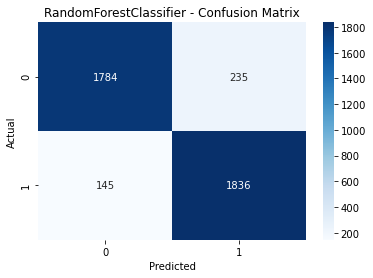

 Plotting Feature Importances...


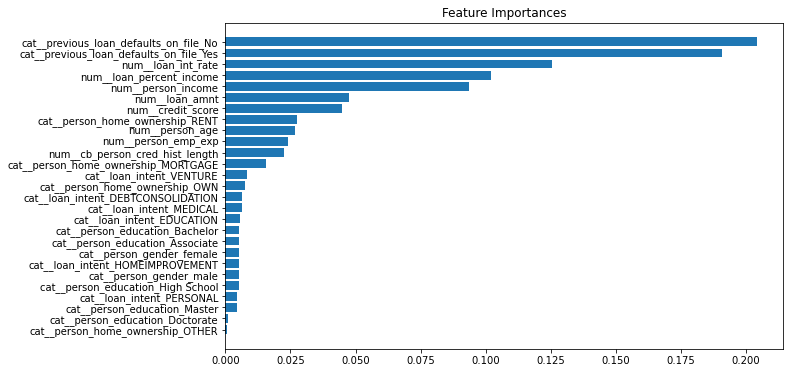

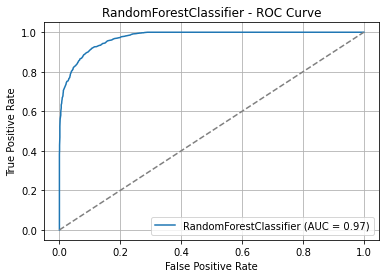

 Class distribution after undersampling:
loan_status
0    10000
1    10000
Name: count, dtype: int64
 Best Parameters for LogisticRegression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
 Best CV Accuracy: 0.8771
 LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      2019
           1       0.85      0.92      0.88      1981

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



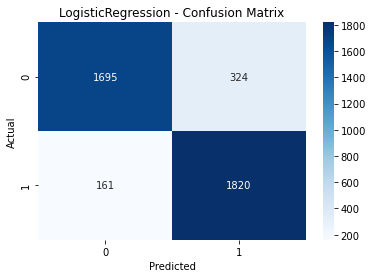

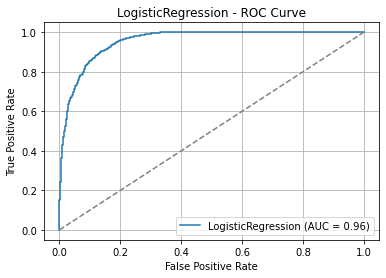

 Class distribution after undersampling:
loan_status
0    10000
1    10000
Name: count, dtype: int64
 Best Parameters for SVC: {'classifier__C': 10, 'classifier__kernel': 'rbf'}
 Best CV Accuracy: 0.8813
 SVC Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      2019
           1       0.86      0.92      0.89      1981

    accuracy                           0.89      4000
   macro avg       0.89      0.89      0.89      4000
weighted avg       0.89      0.89      0.89      4000



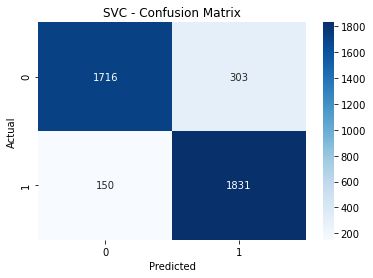

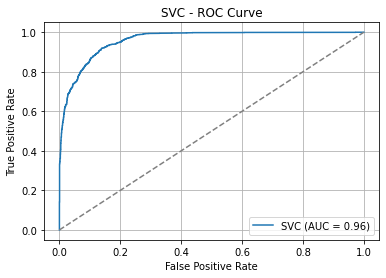

In [2]:
# Load data
df = pd.read_csv("loan_data.csv")

# Define model parameter grids
rf_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5]
}

lr_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__penalty": ["l2"],
    "classifier__solver": ["liblinear"]
}

svc_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__kernel": ["linear", "rbf"]
}

# Run models
rf_model = build_and_evaluate_pipeline(df, "loan_status", RandomForestClassifier(random_state=42), rf_grid)
lr_model = build_and_evaluate_pipeline(df, "loan_status", LogisticRegression(max_iter=1000), lr_grid)
svc_model = build_and_evaluate_pipeline(df, "loan_status", SVC(probability=True), svc_grid)
